<center>
<h1>
Project# 1: 
<center>
    
<center>
<h6>
SQL for Business Analysis: Answering Key Questions
<center>       

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
db = "estore.db"
conn = sql.connect(db)

In [3]:
def run_query(q):
    return pd.read_sql(q, conn)

In [4]:
albums_to_purchase = """ with USA_Tracks_sold as
(select il.* from invoice_line il
inner join invoice i on il.invoice_id = i.invoice_id
inner join customer c on c.customer_id = i.customer_id
where c.country = "USA")



select g.name genre,
count(uts.track_id) tracks_sold,
cast(count(uts.invoice_line_id) as float)/(select count(*) from usa_tracks_sold) percentage_sold
from  USA_Tracks_sold uts
inner join track t 
on t.track_id = uts.track_id
inner join genre g
on g.genre_id = t.genre_id
group by 1
order by 2 desc limit 10


"""
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [5]:
genre_usa = run_query(albums_to_purchase)
genre_usa.set_index('genre', inplace = True, drop = True)


In [6]:
tracks_sold = genre_usa['tracks_sold']
pct_sold = genre_usa['percentage_sold']
pct_sold = (pct_sold*100).astype(int).astype(str)+' %'

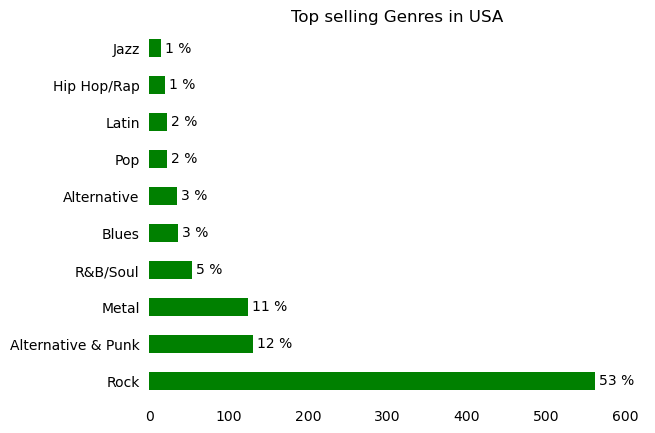

In [20]:
ax = tracks_sold.plot.barh(title = 'Top selling Genres in USA', # setting the title, color of the bars and range of X axis
                    colormap = plt.cm.ocean,
                    xlim =(0,625))
    
plt.ylabel('') #to remove y label
plt.legend('', frameon= False) #to remove legend and legend box
for x, y,txt in zip(tracks_sold, range(10),pct_sold): # labelling the bars
                   plt.annotate(txt, (x +5, y -0.1))
  
ax.tick_params(left = False, bottom  = False) # to remove ticks

for spine in ax.spines.values(): # to remove spines
    spine.set_visible(False)
      
plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums  albums from the **Rock** genre, which accounts for **53%** of sales.

However, It's worth keeping in mind that combined, the below mentioned four genres make up **28%** of total sales, so we should be on the lookout for artists and albums from these genres as well:

* Punk
* Blues
* Pop
* Metal



In [8]:
sales_by_country = """with initial_data as 
(select case when (select count(country) from customer where country = c.country) = 1
then "other" else c.country end as country, 
c.customer_id, il.invoice_id, il.unit_price from customer c
inner join invoice i on i.customer_id = c.customer_id
inner join invoice_line il on il.invoice_id = i.invoice_id
)
select
country,
customers,
total_sales,
average_order,
customer_lifetime_value
from
(select 
country,
count(distinct customer_id) customers,
sum(unit_price) total_sales,
sum(unit_price)/ count(distinct invoice_id) average_order,
sum(unit_price)/ count(distinct customer_id) customer_lifetime_value,
case when country = "other" then 1 else 0 end as table_for_sorting_countries
from initial_data
group by 1 order by table_for_sorting_countries,  total_sales desc
)




"""
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,other,15,1094.94,7.448571,72.996000


In [9]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index('country', inplace = True, drop = True)

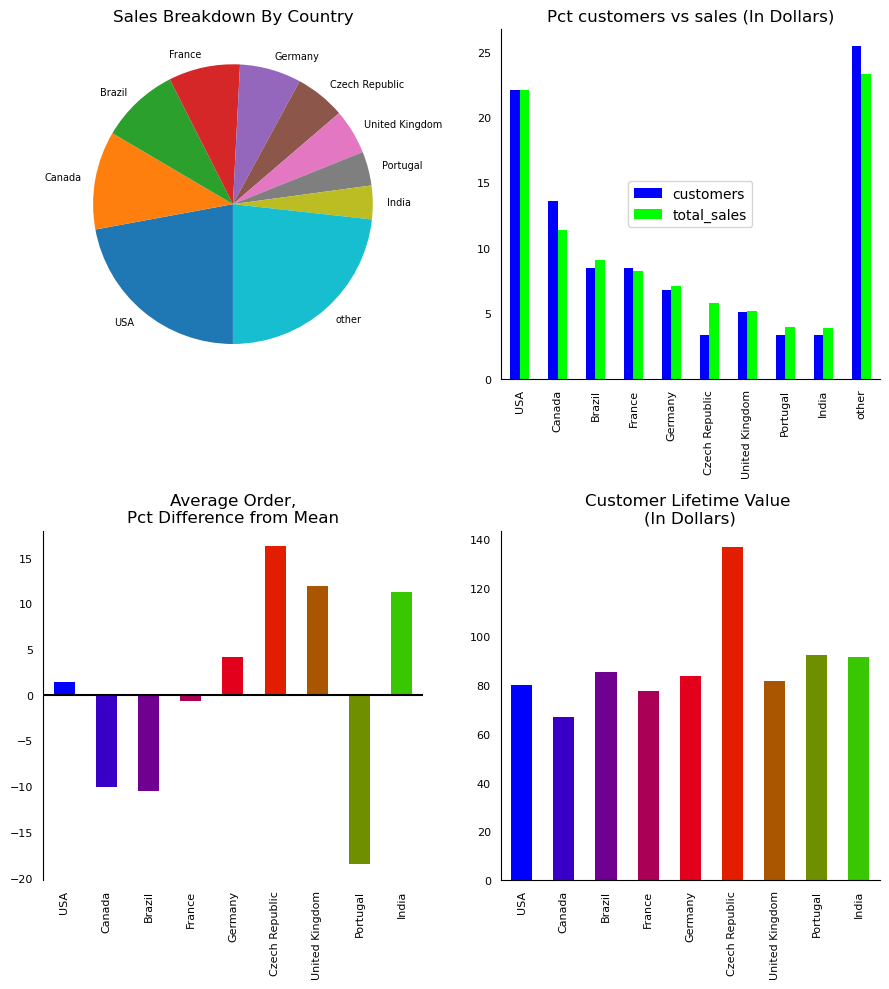

In [51]:
fig, ax = plt.subplots(2,2, figsize = (9,10))
ax1, ax2, ax3, ax4 = ax.flatten()
colors = [plt.cm.brg(i) for i in np.linspace(0, 1, country_metrics.shape[0])] # To assign different color to each bar of graph
# Top left
total_sales = country_metrics['total_sales'].rename('')
total_sales.plot.pie(ax = ax1, title = 'Sales Breakdown By Country',
                    startangle = -90, counterclock = False, fontsize = 7)

# Top Right
cvd =["customers", "total_sales"]
cust_vs_dollars = country_metrics[cvd]
cust_vs_dollars/= (cust_vs_dollars.sum())/100
cust_vs_dollars.plot.bar(ax = ax2, title ='Pct customers vs sales (In Dollars)',
                         colormap = plt.cm.brg, fontsize = 8)
ax2.legend(loc = 'center')
ax2.tick_params(bottom = False, left = False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Bottom Left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name=''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop('other', inplace = True)
difference_from_avg.plot.bar(ax = ax3, title ='Average Order,\nPct Difference from Mean',
                            color = colors, fontsize = 8)
ax3.tick_params(bottom = False, left = False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.axhline(0, color = 'k')

# Bottom Right
cltv = country_metrics['customer_lifetime_value'].copy()
cltv.drop('other', inplace = True)
cltv.plot.bar(ax = ax4, title = 'Customer Lifetime Value \n(In Dollars)',
             fontsize = 8, color = colors)

ax4.tick_params(bottom= False, left = False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()